In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from GPy.models import GPRegression
from GPy.kern import RBF
from scipy.optimize import minimize
from NSGPy.NumPy import LLS
from polire.interpolate import Idw, BSpline, Kriging, Natural_neighbor, SpatialAverage, Trend

## Delhi

In [84]:
data = pd.read_csv('../../data/delhi/delhi-filtered/SpatialCleanAll.csv')
data = data.set_index('utc').sort_index()
data.shape, data.shape[0]/30

((7260, 5), 242.0)

In [85]:
ts = 24*3
sel_index = data.index.unique()[:ts]
sel_data = data.loc[sel_index]
print(sel_data.shape, sel_data.columns, sel_data.shape[0]/30, )

loc_df = sel_data[['location','latitude','longitude']].drop_duplicates('location').set_index('location')
loc_df.index

(2160, 5) Index(['location', 'value', 'mobile', 'latitude', 'longitude'], dtype='object') 72.0


Index(['Anand Vihar, Delhi - DPCC', 'Ashok Vihar, Delhi - DPCC',
       'Aya Nagar, Delhi - IMD', 'Bawana, Delhi - DPCC',
       'CRRI Mathura Road, Delhi - IMD', 'DTU, Delhi - CPCB',
       'Dwarka-Sector 8, Delhi - DPCC ', 'IGI Airport (T3), Delhi - IMD',
       'IHBAS, Dilshad Garden, Delhi - CPCB', 'ITO, Delhi - CPCB',
       'Jahangirpuri, Delhi - DPCC', 'Jawaharlal Nehru Stadium, Delhi - DPCC',
       'Lodhi Road, Delhi - IMD', 'Mundka, Delhi - DPCC',
       'NSIT Dwarka, Delhi - CPCB', 'Najafgarh, Delhi - DPCC',
       'Narela, Delhi - DPCC', 'Nehru Nagar, Delhi - DPCC',
       'Okhla Phase-2, Delhi - DPCC', 'Patparganj, Delhi - DPCC',
       'Punjabi Bagh, Delhi - DPCC', 'R K Puram, Delhi - DPCC',
       'Rohini, Delhi - DPCC', 'Shadipur, Delhi - CPCB',
       'Sirifort, Delhi - CPCB', 'Sonia Vihar, Delhi - DPCC',
       'Sri Aurobindo Marg, Delhi - DPCC', 'US Diplomatic Post: New Delhi',
       'Vivek Vihar, Delhi - DPCC', 'Wazirpur, Delhi - DPCC'],
      dtype='object', name=

In [86]:
multi_data = pd.crosstab(sel_data.index, sel_data.location, sel_data.value, aggfunc=lambda x:x)
multi_data.shape

(72, 30)

### Longitude

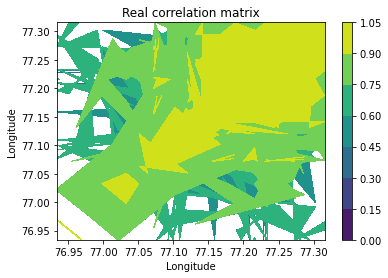

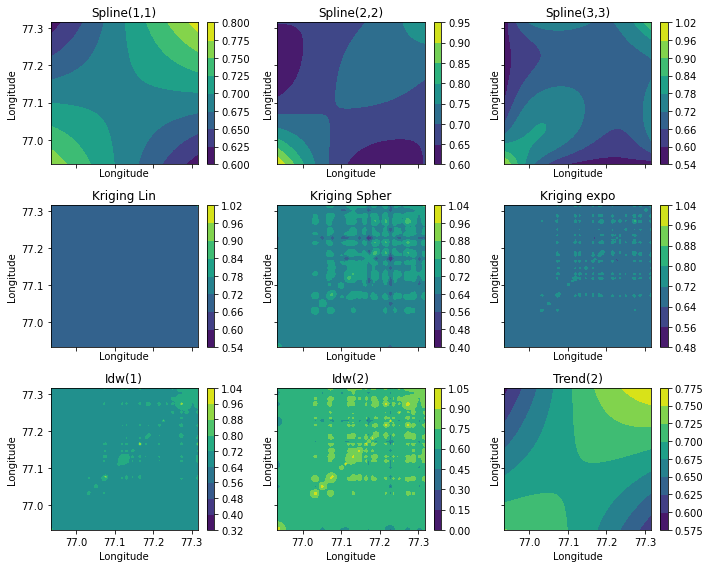

In [87]:
x_real = loc_df.longitude.values
x_uniform = np.linspace(x_real.min(), x_real.max(), 100)
X1_real, X2_real = np.meshgrid(x_real, x_real)
X1_uniform, X2_uniform = np.meshgrid(x_uniform, x_uniform)
X_real = np.array([(i,j) for i,j in zip(X1_real.ravel(), X2_real.ravel())])
X_uniform = np.array([(i,j) for i,j in zip(X1_uniform.ravel(), X2_uniform.ravel())])
plt.contourf(X1_real, X2_real, multi_data.corr())
plt.xlabel('Longitude');plt.ylabel('Longitude')
plt.colorbar();plt.title('Real correlation matrix')

fig, ax = plt.subplots(3,3, figsize=(10,8), sharex=True, sharey=True)
locs = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2),(2,0),(2,1),(2,2)]
names = ['Spline(1,1)', 'Spline(2,2)', 'Spline(3,3)', 'Kriging Lin', 'Kriging Spher', 'Kriging expo',
         'Idw(1)', 'Idw(2)', 'Trend(2)']
for idx, model in enumerate([BSpline(1,1), BSpline(2,2), BSpline(3,3), Kriging(variogram_model='linear'),
                             Kriging(variogram_model='spherical'), Kriging(variogram_model='exponential'),
                             Idw(1), Idw(2), Trend(2)]):
    model.fit(X_real, multi_data.corr().values.ravel())
    Z_uniform = model.predict(X_uniform)
    maped = ax[locs[idx]].contourf(X1_uniform, X2_uniform, Z_uniform.reshape(*X1_uniform.shape))
    ax[locs[idx]].set_xlabel('Longitude');ax[locs[idx]].set_ylabel('Longitude')
    plt.colorbar(maped, ax=ax[locs[idx]]);
#     print(idx)
    names[idx]
    ax[locs[idx]].set_title(names[idx])
plt.tight_layout()

### Latitude

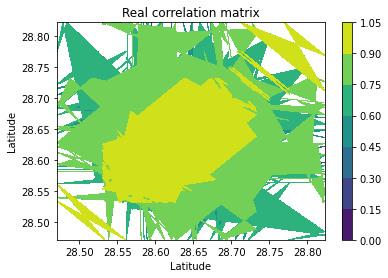

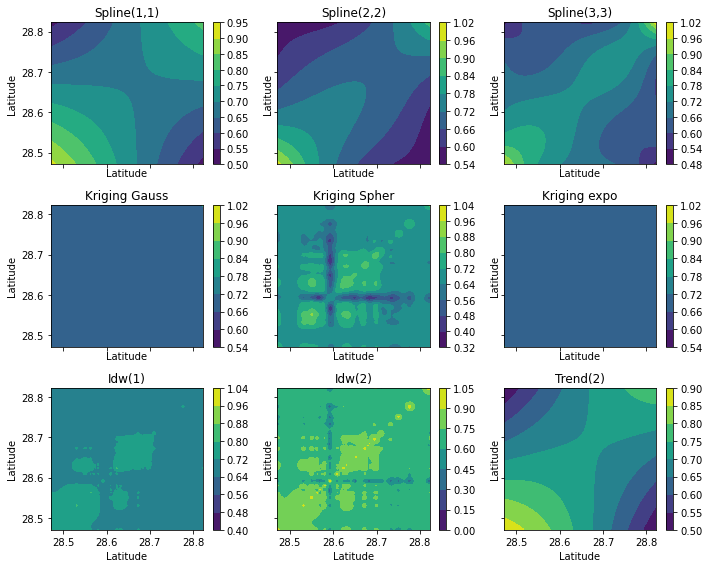

In [88]:
x_real = loc_df.latitude.values
x_uniform = np.linspace(x_real.min(), x_real.max(), 100)
X1_real, X2_real = np.meshgrid(x_real, x_real)
X1_uniform, X2_uniform = np.meshgrid(x_uniform, x_uniform)
X_real = np.array([(i,j) for i,j in zip(X1_real.ravel(), X2_real.ravel())])
X_uniform = np.array([(i,j) for i,j in zip(X1_uniform.ravel(), X2_uniform.ravel())])
plt.contourf(X1_real, X2_real, multi_data.corr())
plt.xlabel('Latitude');plt.ylabel('Latitude')
plt.colorbar();plt.title('Real correlation matrix')

fig, ax = plt.subplots(3,3, figsize=(10,8), sharex=True, sharey=True)
locs = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2),(2,0),(2,1),(2,2)]
names = ['Spline(1,1)', 'Spline(2,2)', 'Spline(3,3)', 'Kriging Gauss', 'Kriging Spher', 'Kriging expo',
         'Idw(1)', 'Idw(2)', 'Trend(2)']
for idx, model in enumerate([BSpline(1,1), BSpline(2,2), BSpline(3,3), Kriging(variogram_model='gaussian'),
                             Kriging(variogram_model='spherical'), Kriging(variogram_model='exponential'),
                             Idw(1), Idw(2), Trend(2)]):
    model.fit(X_real, multi_data.corr().values.ravel())
    Z_uniform = model.predict(X_uniform)
    maped = ax[locs[idx]].contourf(X1_uniform, X2_uniform, Z_uniform.reshape(*X1_uniform.shape))
    ax[locs[idx]].set_xlabel('Latitude');ax[locs[idx]].set_ylabel('Latitude')
    plt.colorbar(maped, ax=ax[locs[idx]]);
#     print(idx)
    names[idx]
    ax[locs[idx]].set_title(names[idx])
plt.tight_layout()

### Beijing

In [89]:
# ts = 24*3
data = pd.read_csv('../../data/beijing/beijing_corrected_data.csv').set_index('utc_time')
loc_df = pd.read_csv('../../data/beijing/beijing_corrected_locs.csv')

sel_index = data.index.unique()[:ts]
sel_data = data.loc[b_sel_index]
sel_data.shape, sel_data.shape[0]/35, sel_data.columns

((2520, 7),
 72.0,
 Index(['stationId', 'PM2.5', 'PM10', 'NO2', 'CO', 'O3', 'SO2'], dtype='object'))

In [90]:
multi_data = pd.crosstab(sel_data.index, sel_data.stationId, sel_data['PM2.5'], aggfunc=lambda x:x)
multi_data.shape

(72, 35)

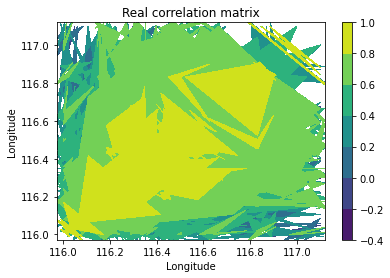

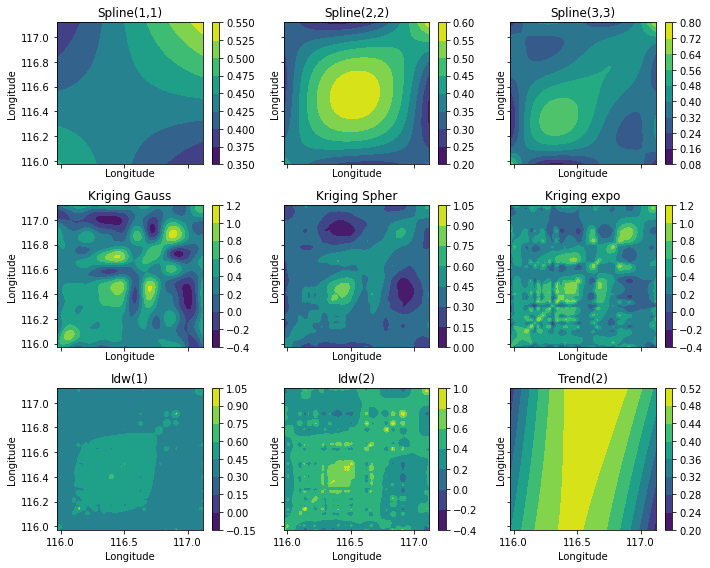

In [91]:
x_real = loc_df.longitude.values
x_uniform = np.linspace(x_real.min(), x_real.max(), 100)
X1_real, X2_real = np.meshgrid(x_real, x_real)
X1_uniform, X2_uniform = np.meshgrid(x_uniform, x_uniform)
X_real = np.array([(i,j) for i,j in zip(X1_real.ravel(), X2_real.ravel())])
X_uniform = np.array([(i,j) for i,j in zip(X1_uniform.ravel(), X2_uniform.ravel())])
plt.contourf(X1_real, X2_real, multi_data.corr())
plt.xlabel('Longitude');plt.ylabel('Longitude')
plt.colorbar();plt.title('Real correlation matrix')

fig, ax = plt.subplots(3,3, figsize=(10,8), sharex=True, sharey=True)
locs = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2),(2,0),(2,1),(2,2)]
names = ['Spline(1,1)', 'Spline(2,2)', 'Spline(3,3)', 'Kriging Gauss', 'Kriging Spher', 'Kriging expo',
         'Idw(1)', 'Idw(2)', 'Trend(2)']
for idx, model in enumerate([BSpline(1,1), BSpline(2,2), BSpline(3,3), Kriging(variogram_model='gaussian'),
                             Kriging(variogram_model='spherical'), Kriging(variogram_model='exponential'),
                             Idw(1), Idw(2), Trend(2)]):
    model.fit(X_real, multi_data.corr().values.ravel())
    Z_uniform = model.predict(X_uniform)
    maped = ax[locs[idx]].contourf(X1_uniform, X2_uniform, Z_uniform.reshape(*X1_uniform.shape))
    ax[locs[idx]].set_xlabel('Longitude');ax[locs[idx]].set_ylabel('Longitude')
    plt.colorbar(maped, ax=ax[locs[idx]]);
#     print(idx)
    names[idx]
    ax[locs[idx]].set_title(names[idx])
plt.tight_layout()

### Latitude

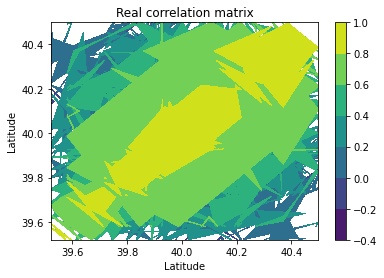

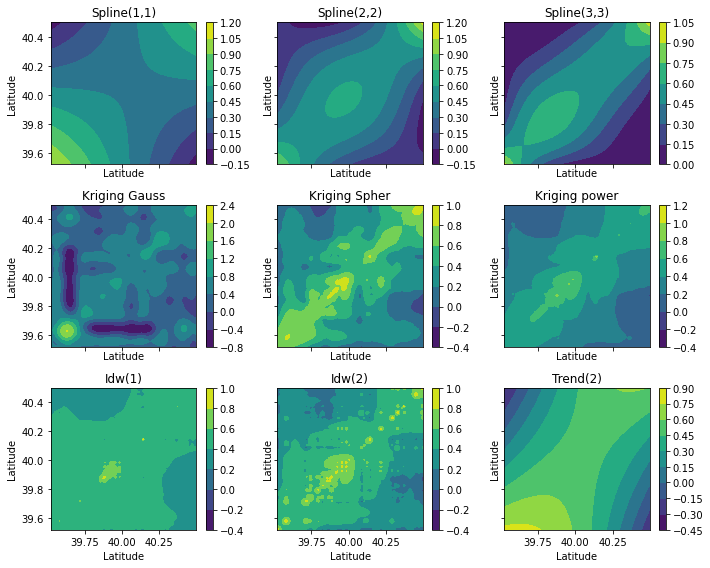

In [92]:
x_real = loc_df.latitude.values
x_uniform = np.linspace(x_real.min(), x_real.max(), 100)
X1_real, X2_real = np.meshgrid(x_real, x_real)
X1_uniform, X2_uniform = np.meshgrid(x_uniform, x_uniform)
X_real = np.array([(i,j) for i,j in zip(X1_real.ravel(), X2_real.ravel())])
X_uniform = np.array([(i,j) for i,j in zip(X1_uniform.ravel(), X2_uniform.ravel())])
plt.contourf(X1_real, X2_real, multi_data.corr())
plt.xlabel('Latitude');plt.ylabel('Latitude')
plt.colorbar();plt.title('Real correlation matrix')

fig, ax = plt.subplots(3,3, figsize=(10,8), sharex=True, sharey=True)
locs = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2),(2,0),(2,1),(2,2)]
names = ['Spline(1,1)', 'Spline(2,2)', 'Spline(3,3)', 'Kriging Gauss', 'Kriging Spher', 'Kriging power',
         'Idw(1)', 'Idw(2)', 'Trend(2)']
for idx, model in enumerate([BSpline(1,1), BSpline(2,2), BSpline(3,3), Kriging(variogram_model='gaussian'),
                             Kriging(variogram_model='spherical'), Kriging(variogram_model='power'),
                             Idw(1), Idw(2), Trend(2)]):
    model.fit(X_real, multi_data.corr().values.ravel())
    Z_uniform = model.predict(X_uniform)
    maped = ax[locs[idx]].contourf(X1_uniform, X2_uniform, Z_uniform.reshape(*X1_uniform.shape))
    ax[locs[idx]].set_xlabel('Latitude');ax[locs[idx]].set_ylabel('Latitude')
    plt.colorbar(maped, ax=ax[locs[idx]]);
#     print(idx)
    names[idx]
    ax[locs[idx]].set_title(names[idx])
plt.tight_layout()